# 1/15/21 - Starting a master notebook that covers all the steps conducted in previous notebooks.

In [55]:
# libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from astropy import constants as const
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value

c = const.c.to('km/s').value #c in km/s
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
cosmo = FlatLambdaCDM(h0, Om0=0.262)

# paths
csv_path = '/data/sknabel/autoz_lens_model/files/csv/'
latest_path= f'{csv_path}latest/'
png_path = '/data/sknabel/autoz_lens_model/visuals/png/'
knabel2020_file_path = '/data/sknabel/lens_methods/files/'

In [11]:
# load autoz csv
autoz = pd.read_csv(f'{csv_path}autoz.csv')
print(len(autoz))

166332


In [25]:
# load catalogs from LinKS, Li, and Zoo

# load LinKS files from Knabel-2020 (initial and final selections, should be 421 and 47)
links_initial_data = pd.read_csv(f'{knabel2020_file_path}mac_in_gama_withgamaid.csv')
print(len)
# drop null values, objects that didn't match the gama catalog
links = links_initial_data.dropna(axis=0, subset=['GAMA_ID'])
# load the selection from Knabel-2020
links_knabel = pd.read_csv(f'{knabel2020_file_path}mac_latest.csv')

# load Li-2020 files
li_data = pd.read_csv(f'{csv_path}li_match_to_gama_spec.csv')
# drop 0 values, objects that didn't match the gama catalog
li_data.GAMA_ID.replace(0, np.nan, inplace=True)
li = li_data.dropna(axis=0, subset=['GAMA_ID'])

# load Zoo files
zoo = pd.read_csv(f'{knabel2020_file_path}zoo_latest.csv')

print(len(links), len(links_knabel), len(li), len(zoo))

<built-in function len>
305 47 32 13


In [27]:
# merge links catalogs with autoz

links_autoz = pd.merge(links, autoz, how = 'left', on = 'GAMA_ID')
links_knabel_autoz = pd.merge(links_knabel, autoz, how = 'left', on = 'GAMA_ID')
li_autoz = pd.merge(li, autoz, how = 'left', on = 'GAMA_ID')
zoo_autoz = pd.merge(zoo, autoz, how = 'left', on = 'GAMA_ID')

print(len(links_autoz), len(links_knabel_autoz), len(li_autoz), len(zoo_autoz))

348 51 37 13


### Template matches are given as cross-correlation peaks given by their sigma value, with up to four matches.
### We want sigmas 1 and 2 to be significantly higher than sigmas 3 and 4, showing a double spectral profile.
### $R = \sigma_2/\sqrt{(\sigma_3)^2/2+(\sigma_4)^2/2}$

In [29]:
# Select based on R > 1.2
links_select = links_autoz[links_autoz.R > 1.2]
links_knabel_select = links_knabel_autoz[links_knabel_autoz.R > 1.2]
li_select = li_autoz[li_autoz.R > 1.2]
zoo_select = zoo_autoz[zoo_autoz.R > 1.2]
print(len(links_select), len(links_knabel_select), len(li_select), len(zoo_select))

59 7 8 0


Text(0.5, 1.0, 'Selection Based on $\\sigma$ and R Values')

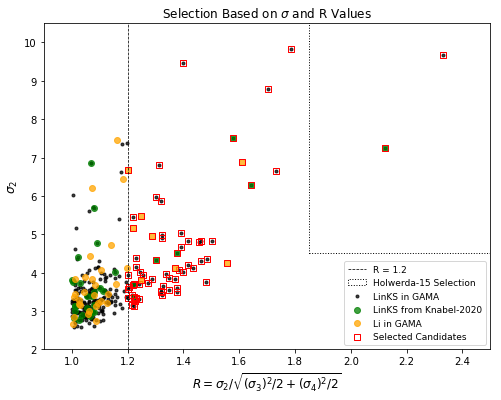

In [51]:
# visualize selection

fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xlim(0.9, 2.5)
ax.set_ylim(2.0, 10.5)
ax.scatter(links_autoz.R,
          links_autoz.sigma2,
          color = 'k',
          marker = '.',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_autoz.R,
           links_knabel_autoz.sigma2,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS from Knabel-2020')
ax.scatter(links_select.R,
          links_select.sigma2,
          facecolor= 'none',
          marker = 's',
          edgecolor = 'r',
          label = '_Selected Candidates')
ax.scatter(li_autoz.R,
           li_autoz.sigma2,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li in GAMA')
ax.scatter(li_select.R,
          li_select.sigma2,
          facecolor= 'none',
          marker = 's',
          edgecolor = 'r',
          label = 'Selected Candidates')
ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
                               edgecolor = 'k', facecolor = 'none', linestyle = ':',
                              label = 'Holwerda-15 Selection'))
ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
plt.legend(fontsize=9)
ax.set_xlabel('$R = \sigma_2/\sqrt{(\sigma_3)^2/2+(\sigma_4)^2/2}$', fontsize = 12)
ax.set_ylabel('$\sigma_2$',  fontsize = 12)
ax.set_title('Selection Based on $\sigma$ and R Values')
#plt.show()

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/sigma_selection062020.png')

In [52]:
# designate template types (positions of ELGs and/or PGs)
#########
# links
pg_elg1 = links_select[(links_select.z1 < links_select.z2) & (links_select.template1 >=40) & (links_select.template1 <= 42) 
             & (links_select.template2 > 42) & (links_select.template2 <= 47)]
pg_elg2 = links_select[(links_select.z1 > links_select.z2) & (links_select.template2 >=40) & (links_select.template2 <= 42)
             & (links_select.template1 > 42) & (links_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
print(len(pg_elg))

elg_pg1 = links_select[(links_select.z1 < links_select.z2) & (links_select.template2 >=40) & (links_select.template2 <= 42)
             & (links_select.template1 > 42) & (links_select.template1 <= 47)]
elg_pg2 = links_select[(links_select.z1 > links_select.z2) & (links_select.template1 >=40) & (links_select.template1 <= 42)
             & (links_select.template2 > 42) & (links_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
print(len(elg_pg))

elg_elg = links_select[(links_select.template2 >= 40) & (links_select.template2 <= 42) & (links_select.template1 >=40 ) & (links_select.template1 <= 42)]
elg_elg['type'] = 'ELG + ELG'
pg_pg = links_select[(links_select.template1 > 42) & (links_select.template2 <= 47) & (links_select.template2 > 42) & (links_select.template2 <= 47)]
pg_pg['type'] = 'PG + PG'
print(len(elg_elg))
print(len(pg_pg))

links_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'links_select: {len(links_select_types)}')

##########
#links_knabel
pg_elg1 = links_knabel_select[(links_knabel_select.z1 < links_knabel_select.z2) & (links_knabel_select.template1 >=40) & (links_knabel_select.template1 <= 42) 
             & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]
pg_elg2 = links_knabel_select[(links_knabel_select.z1 > links_knabel_select.z2) & (links_knabel_select.template2 >=40) & (links_knabel_select.template2 <= 42)
             & (links_knabel_select.template1 > 42) & (links_knabel_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
print(len(pg_elg))

elg_pg1 = links_knabel_select[(links_knabel_select.z1 < links_knabel_select.z2) & (links_knabel_select.template2 >=40) & (links_knabel_select.template2 <= 42)
             & (links_knabel_select.template1 > 42) & (links_knabel_select.template1 <= 47)]
elg_pg2 = links_knabel_select[(links_knabel_select.z1 > links_knabel_select.z2) & (links_knabel_select.template1 >=40) & (links_knabel_select.template1 <= 42)
             & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
print(len(elg_pg))

elg_elg = links_knabel_select[(links_knabel_select.template2 >= 40) & (links_knabel_select.template2 <= 42) & (links_knabel_select.template1 >=40 ) & (links_knabel_select.template1 <= 42)]
elg_elg['type'] = 'ELG + ELG'
pg_pg = links_knabel_select[(links_knabel_select.template1 > 42) & (links_knabel_select.template2 <= 47) & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]
pg_pg['type'] = 'PG + PG'
print(len(elg_elg))
print(len(pg_pg))

links_knabel_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'links_knabel_select: {len(links_knabel_select_types)}')
#############
#li
pg_elg1 = li_select[(li_select.z1 < li_select.z2) & (li_select.template1 >=40) & (li_select.template1 <= 42) 
             & (li_select.template2 > 42) & (li_select.template2 <= 47)]
pg_elg2 = li_select[(li_select.z1 > li_select.z2) & (li_select.template2 >=40) & (li_select.template2 <= 42)
             & (li_select.template1 > 42) & (li_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
print(len(pg_elg))

elg_pg1 = li_select[(li_select.z1 < li_select.z2) & (li_select.template2 >=40) & (li_select.template2 <= 42)
             & (li_select.template1 > 42) & (li_select.template1 <= 47)]
elg_pg2 = li_select[(li_select.z1 > li_select.z2) & (li_select.template1 >=40) & (li_select.template1 <= 42)
             & (li_select.template2 > 42) & (li_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
print(len(elg_pg))

elg_elg = li_select[(li_select.template2 >= 40) & (li_select.template2 <= 42) & (li_select.template1 >=40 ) & (li_select.template1 <= 42)]
elg_elg['type'] = 'ELG + ELG'
pg_pg = li_select[(li_select.template1 > 42) & (li_select.template2 <= 47) & (li_select.template2 > 42) & (li_select.template2 <= 47)]
pg_pg['type'] = 'PG + PG'
print(len(elg_elg))
print(len(pg_pg))

li_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'li_select: {len(li_select_types)}')

26
12
10
8
links_select: 56
5
1
1
0
links_knabel_select: 7
2
2
0
4
li_select: 8


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Text(0.5, 1.0, 'Spectral Template Pair Types for Selected Candidates')

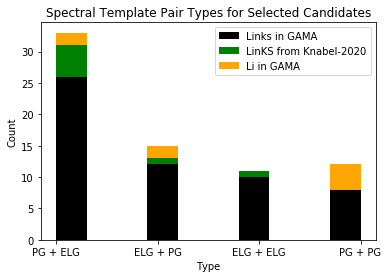

In [53]:
plt.hist([links_select_types.type, links_knabel_select_types.type, li_select_types.type],
        color = ['k','g','orange'],
         label = ['Links in GAMA', 'LinKS from Knabel-2020', 'Li in GAMA'],
         stacked = True)#, density = True)
plt.legend()
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Spectral Template Pair Types for Selected Candidates')

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/template_pair_types_select.png')

Prepare samples for modeling by determining z_lens and z_source (and D_lens and D_source) from z1 and z2, correcting M* for z_lens where Z = z_source $$M_{*correct} = M_* (D_{source}^2/D_{lens}^2)$$

In [57]:
# load lambdar mass catalog
# import lambdarstellarmasses
# Opening GAMA data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/autoz_lens_model/files/fits/StellarMassesLambdar.fits')  # open a FITS file
hdul.verify('fix')
masses = hdul[1].data  # assume the first extension is a table
#print(masses.columns)



# create dataframe of masses objects to compare to candidates
GAMA_ID = masses.CATAID.byteswap().newbyteorder()
logmstar = masses.logmstar.byteswap().newbyteorder()
logmintsfh = masses.logmintsfh.byteswap().newbyteorder()
logmremnants = masses.logmremnants.byteswap().newbyteorder()
fluxscale = masses.fluxscale.byteswap().newbyteorder()
dellogmintsfh = masses.dellogmintsfh.byteswap().newbyteorder()
z = masses.Z.byteswap().newbyteorder()

#masses_list = list(zip(GAMA_ID, logmstar, logmintsfh, logmremnants, fluxscale))

#masses_list
lambdar_masses = pd.DataFrame(
    {'GAMA_ID' : GAMA_ID,
#     'logmstar' : logmstar, 
     'lambdar_log_mstar' : logmintsfh,
    'lambdar_mstar' : 10**(logmintsfh),
    'lambdar_log_mstar_error': dellogmintsfh,
    'z': z}
) 
#     'logmremnants' : logmremnants, 
#     'fluxscale' : fluxscale})
lambdar_masses.GAMA_ID = lambdar_masses.GAMA_ID.astype(int)
print(len(lambdar_masses))



FileNotFoundError: [Errno 2] No such file or directory: '/home/shawn/Desktop/autoz_lens_model/files/fits/StellarMassesLambdar.fits'

AttributeError: 'DataFrame' object has no attribute 'zlens'

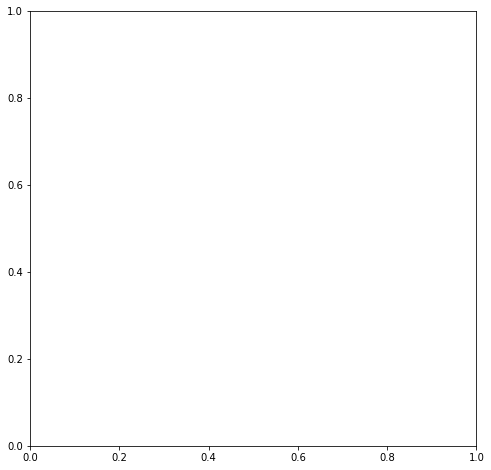

In [54]:
# check lens and source redshifts for reasonability
# plots
x = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 0.8)
ax.scatter(links_select.zlens,
          links_select.zsource,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_select.zlens,
           links_knabel_select.zsource,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS from Knabel-2020')
ax.scatter(li_select.zlens,
           li_select.zsource,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li in GAMA')
#ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_xlabel('$z_{lens}$', fontsize = 12)
ax.set_ylabel('$z_{source}$',  fontsize = 12)
ax.set_title('$z_{lens}$ to $z_{source}$')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect(1)
ax.plot(x, x, color = 'k', linestyle = '-')
ax.plot(x, x + 0.1, color = 'k', linestyle = '--')
#ax.plot(x, x - 0.1, color = 'k', linestyle = '--')
plt.fill_between(x, x, x+0.1, # Fill region for false candidates
                 facecolor="cyan", # The fill color
                 color='cyan',       # The outline color
                 alpha=0.15, # Transparency of the fill
                label='$\Delta$z < 0.1') # plots
x = np.linspace(0, 1, 100)


#ax.set_xlim(0, 1)
#ax.set_ylim(0, 0.8)

#ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
ax.axvline(0.05, color = 'k', linewidth = .75, linestyle = '-.', label = '$z_{lens}$ = 0.01')

plt.legend()
#plt.show()

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/zlens_to_zsource_061520.png')
